In [1]:
%load_ext autoreload
%autoreload 2

here the objective is to fit the logit graph model to multiple different graph domains and then visualize the original vs fitted graphs

In [6]:

import sys
import os

#Graph imports
sys.path.append('../..')
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

from src.simulation import LogitGraphFitter, GraphModelComparator

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [9]:
data_directory = f'../../data/misc/gplus'
os.listdir(data_directory)
ids = [int(f.split('.')[0]) for f in os.listdir(data_directory) if f.endswith('.edges')]
len(ids)

132

In [10]:
def load_twitter_graph(data_dir, graph_id):
    """
    Loads a Facebook graph from the specified directory and graph ID.

    Args:
        data_dir (str): The directory where the facebook data is stored.
        graph_id (int): The ID of the graph to load.

    Returns:
        networkx.Graph: The loaded graph as a networkx Graph object.
    """
    edge_file = os.path.join(data_dir, f"{graph_id}.edges")
    
    G = nx.Graph()
    
    with open(edge_file, 'r') as f:
        for line in f:
            # The files are space-separated, so we split the line
            # and convert the node IDs to integers.
            u, v = map(int, line.strip().split())
            G.add_edge(u, v)
            
    return G


graphs = []
graph_filepaths = {}
for graph_id in ids:
    graph = load_twitter_graph(data_directory, graph_id)
    if graph:
        graphs.append(graph)
        graph_filepaths[graph] = os.path.join(data_directory, f"{graph_id}.edges")
        print(f"Graph {graph_id} loaded successfully. Edges: {graph.number_of_edges()}, Nodes: {graph.number_of_nodes()}")



Graph 112787435697866537461 loaded successfully. Edges: 1143015, Nodes: 4926
Graph 116825083494890429556 loaded successfully. Edges: 430977, Nodes: 4604
Graph 111213696402662884531 loaded successfully. Edges: 7624, Nodes: 258
Graph 102615863344410467759 loaded successfully. Edges: 1169, Nodes: 102
Graph 117798157258572080176 loaded successfully. Edges: 892, Nodes: 168
Graph 116315897040732668413 loaded successfully. Edges: 94278, Nodes: 1243
Graph 114336431216099933033 loaded successfully. Edges: 4546, Nodes: 461
Graph 107459220492917008623 loaded successfully. Edges: 12000, Nodes: 562
Graph 100518419853963396365 loaded successfully. Edges: 8180, Nodes: 326
Graph 111048918866742956374 loaded successfully. Edges: 480779, Nodes: 4160
Graph 115573545440464933254 loaded successfully. Edges: 257072, Nodes: 4503
Graph 113455290791279442483 loaded successfully. Edges: 2352, Nodes: 108
Graph 100521671383026672718 loaded successfully. Edges: 16558, Nodes: 521
Graph 113718775944980638561 loaded 

### Fitting single graph

Loading the different graphs into a networkx graph

In [32]:
# Let's proceed with the first loaded graph if available
if not graphs:
    print("\nNo graphs were loaded. Exiting example.")
    exit()

target_graph = graphs[1]
target_filepath = graph_filepaths[target_graph]

# For a single fit, you need to specify a single `d`
fitter_params = {
    "d": 0,
    "n_iteration": 8000,
    "patience": 10,
    "er_p": 0.05,
    "edge_delta": 50,
    "min_gic_threshold": 0.1,
    "verbose": True
}

# Initialize the fitter with the parameters

lg_fitter = LogitGraphFitter(**fitter_params)
lg_fitter.fit(target_graph)



==================== Processing Graph ====================
Original graph - Nodes: 218, Edges: 1725
Running LG generation for d=0...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2121
   📈 Results Summary
   🏆 Best iteration found: 634
   📊 Best spectrum difference: 196.9655
   🔗 Edges in best graph: 1776 (Real graph edges: 1725)
Fitting successful - GIC: 0.2101, Best iteration: 634
Fitted graph - Nodes: 218, Edges: 1776


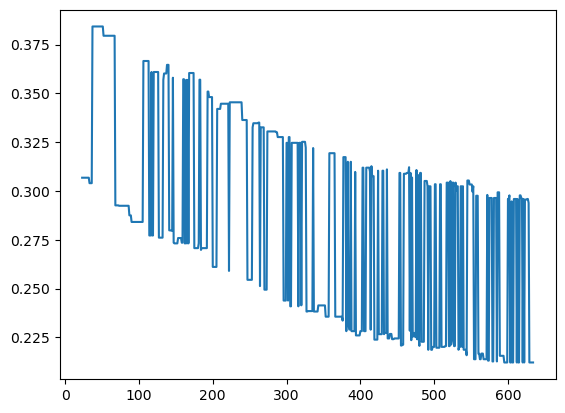

In [33]:
# Log the gic also with the spectrum digg and edges
plt.plot(lg_fitter.metadata['gic_values'])

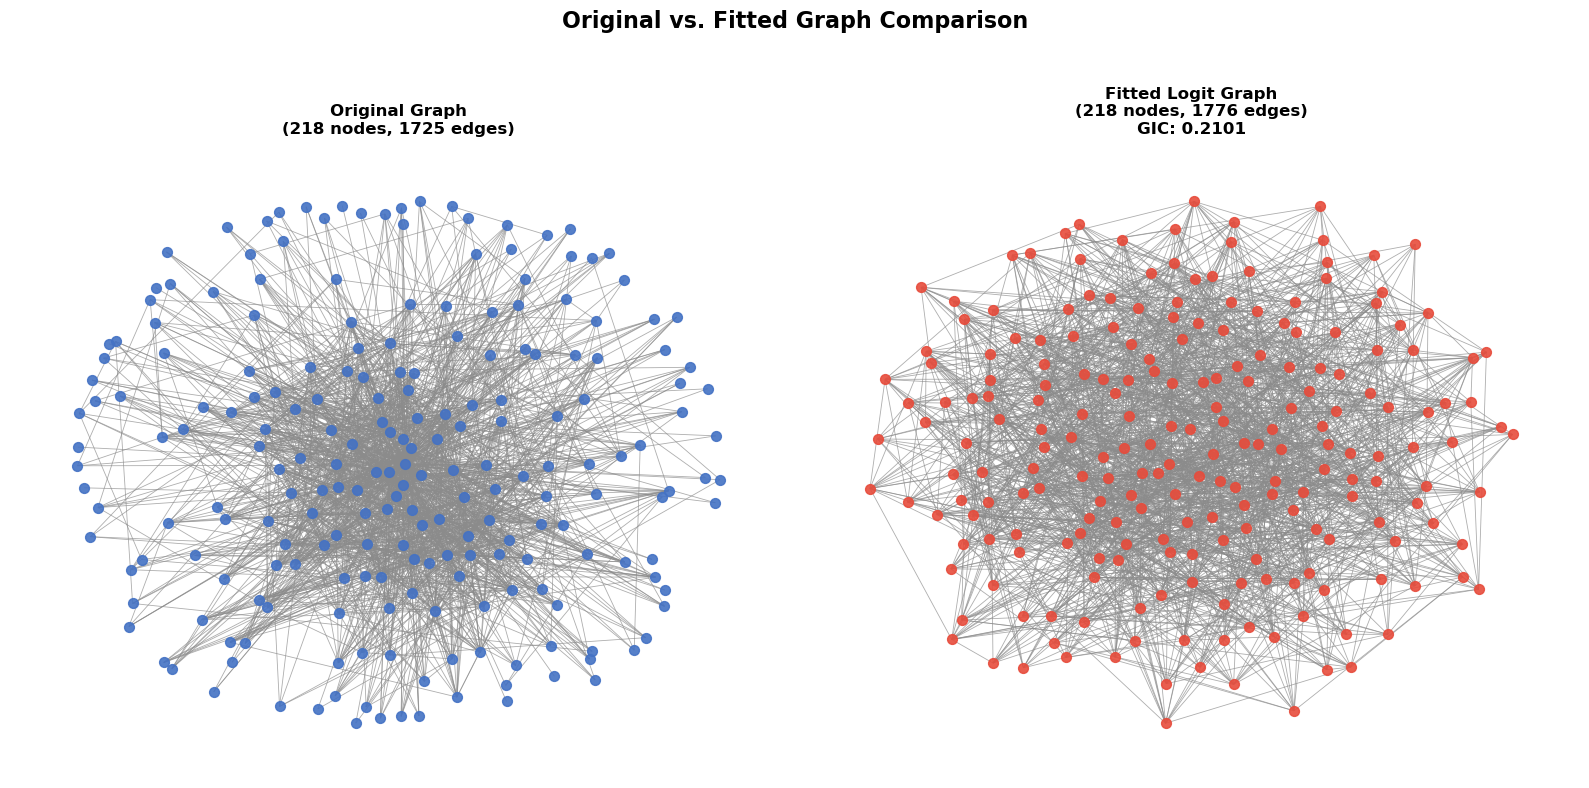

In [34]:
def compare_graphs_visually(original_graph, fitted_graph, metadata=None, figsize=(16, 8), node_size=50, edge_width=0.6):
    """
    Generates a side-by-side plot of the original and fitted graphs.

    Args:
        original_graph (nx.Graph): The original graph.
        fitted_graph (nx.Graph): The fitted graph (can be None if fitting failed).
        metadata (dict, optional): Fitting metadata to display in titles.
        figsize (tuple): The size of the matplotlib figure.
        node_size (int): The size of the nodes in the plot.
        edge_width (float): The width of the edges in the plot.

    Returns:
        matplotlib.figure.Figure: The figure object for the plot.
    """
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Define colors and use a consistent layout for better comparison
    original_node_color = '#4472C4'
    fitted_node_color = '#E74C3C'
    edge_color = '#8B8B8B'
    
    # Calculate layout for original graph
    pos_orig = nx.spring_layout(original_graph, k=1, iterations=50, seed=42)
    
    # 1. Plot Original Graph
    ax_orig = axes[0]
    stats_orig = f"{original_graph.number_of_nodes()} nodes, {original_graph.number_of_edges()} edges"
    nx.draw_networkx_edges(original_graph, pos_orig, ax=ax_orig, edge_color=edge_color, width=edge_width, alpha=0.7)
    nx.draw_networkx_nodes(original_graph, pos_orig, ax=ax_orig, node_color=original_node_color, node_size=node_size, alpha=0.9)
    ax_orig.set_title(f'Original Graph\n({stats_orig})', fontweight='bold', pad=10)
    ax_orig.axis('off')

    # 2. Plot Fitted Graph
    ax_fitted = axes[1]
    title = 'Fitted Logit Graph'
    if fitted_graph and metadata and metadata.get('fit_success'):
        stats_fitted = f"{fitted_graph.number_of_nodes()} nodes, {fitted_graph.number_of_edges()} edges"
        gic_val = metadata.get('gic_value', 'N/A')
        gic_text = f"GIC: {gic_val:.4f}" if isinstance(gic_val, (int, float)) else f"GIC: {gic_val}"
        title = f'{title}\n({stats_fitted})\n{gic_text}'
        
        # Calculate separate layout for fitted graph to avoid position mismatch
        pos_fitted = nx.spring_layout(fitted_graph, k=1, iterations=50, seed=42)
        
        nx.draw_networkx_edges(fitted_graph, pos_fitted, ax=ax_fitted, edge_color=edge_color, width=edge_width, alpha=0.7)
        nx.draw_networkx_nodes(fitted_graph, pos_fitted, ax=ax_fitted, node_color=fitted_node_color, node_size=node_size, alpha=0.9)
    else:
        title = f'{title}\n(Fitting Failed)'
        ax_fitted.text(0.5, 0.5, 'Fitting Failed', horizontalalignment='center', verticalalignment='center', transform=ax_fitted.transAxes, fontsize=14, color='red')

    ax_fitted.set_title(title, fontweight='bold', pad=10)
    ax_fitted.axis('off')
    
    fig.suptitle('Original vs. Fitted Graph Comparison', fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    
    return fig


# 5. Visualize the results
if lg_fitter.metadata['fit_success']:
    comparison_figure = compare_graphs_visually(target_graph, lg_fitter.fitted_graph, lg_fitter.metadata)
    plt.show()
else:
    print("Fitting failed. No visualization available.")


In [50]:
# Let's proceed with the first loaded graph if available
if not graphs:
    print("\nNo graphs were loaded. Exiting example.")
    exit()

target_graph = graphs[2]
target_filepath = graph_filepaths[target_graph]

# For a single fit, you need to specify a single `d`
sim_params = {
    "d_list": [0, 1, 2],
    "lg_params": {
        "max_iterations": 8000,
        "patience": 10,
        "gic_dist_type": 'KL',
        "er_p": 0.05,
        "min_gic_threshold": 0.1,
        "edge_delta": 50,
        "verbose": True,
    },
    "other_model_n_runs": 5,
    "other_model_params": [
        {'lo': 0.01, 'hi': 0.2},  # ER (probability)
        {'k': {'lo': 2, 'hi': 3, 'step': 1}, 'p': {'lo': 0.01, 'hi': 0.2}},  # WS
        {'lo': 1, 'hi': 3},      # GRG (alpha)
        {'lo': 3, 'hi': 5},     # BA (m)
    ],
    "verbose": True,
}



# Initialize the fitter with the parameters

comparator = GraphModelComparator(**sim_params)
comparator.compare(target_graph, target_filepath)



============================== Processing Graph: 96907622.edges ==============================

--- Fitting Logit Graph (LG) model ---
Running LG generation for d=0...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4346 (Target: ≤0.1) 📈 Best Spectrum Diff: 572.4733 ⏱️  Patience: 0/10 🔗 Edges: 1766 (Target: 4649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3615 (Target: ≤0.1) 📈 Best Spectrum Diff: 474.1305 ⏱️  Patience: 0/10 🔗 Edges: 2633 (Target: 4649)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4667 (Target: ≤0.1) 📈 Best Spectrum Diff: 403.6383 ⏱️  Patience: 0/10 🔗 Edges: 3453 (Target: 4649)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2190 (Target: ≤0.1) 📈 Best Spectrum Diff: 358.5826 ⏱️  Patience: 0/10 🔗 Edges: 4234 (Target: 4649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4033
   📈 Results Summary
   🏆 Best iteration found: 4,584
   📊 Best spectrum difference: 348.8605
   🔗 Edges in best graph: 4674 (Real graph edges: 4649)
d=0: GIC=0.2042, sigma=-5.4737
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4181 (Target: ≤0.1) 📈 Best Spectrum Diff: 566.4874 ⏱️  Patience: 0/10 🔗 Edges: 1813 (Target: 4649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5644 (Target: ≤0.1) 📈 Best Spectrum Diff: 471.9589 ⏱️  Patience: 0/10 🔗 Edges: 2678 (Target: 4649)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4667 (Target: ≤0.1) 📈 Best Spectrum Diff: 400.6161 ⏱️  Patience: 0/10 🔗 Edges: 3511 (Target: 4649)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2135 (Target: ≤0.1) 📈 Best Spectrum Diff: 359.2674 ⏱️  Patience: 0/10 🔗 Edges: 4275 (Target: 4649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4069
   📈 Results Summary
   🏆 Best iteration found: 4,528
   📊 Best spectrum difference: 351.4274
   🔗 Edges in best graph: 4660 (Real graph edges: 4649)
d=1: GIC=0.4069, sigma=-6.2316
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4336 (Target: ≤0.1) 📈 Best Spectrum Diff: 569.1227 ⏱️  Patience: 0/10 🔗 Edges: 1812 (Target: 4649)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5529 (Target: ≤0.1) 📈 Best Spectrum Diff: 471.6666 ⏱️  Patience: 0/10 🔗 Edges: 2689 (Target: 4649)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2589 (Target: ≤0.1) 📈 Best Spectrum Diff: 404.2305 ⏱️  Patience: 0/10 🔗 Edges: 3486 (Target: 4649)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2111 (Target: ≤0.1) 📈 Best Spectrum Diff: 364.2727 ⏱️  Patience: 0/10 🔗 Edges: 4277 (Target: 4649)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4048
   📈 Results Summary
   🏆 Best iteration found: 4,409
   📊 Best spectrum difference: 358.2911
   🔗 Edges in best graph: 4577 (Real graph edges: 4649)
d=2: GIC=0.2048, sigma=-80.5871
Best LG fit found with GIC: 0.2042

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.2723181008317491
Tes

In [52]:
comparator.summary_df

,graph_filename,model,gic_value,param,fit_success,nodes,edges,density,avg_clustering,avg_path_length,diameter,assortativity,num_components,largest_component_size
0,96907622.edges,Original,NaN,N/A,True,187,4649,0.267322,0.598147,1.749955,4,-0.223390,2,183
1,96907622.edges,LG,0.204187,"d=0, sigma=-5.4737",True,187,4674,0.268760,0.269265,1.731240,2,-0.021158,1,187
2,96907622.edges,ER,0.272318,0.2,True,187,3385,0.194641,0.196904,1.806107,3,-0.001703,1,187
3,96907622.edges,BA,0.721498,5.0,True,187,910,0.052326,0.129281,2.433673,4,-0.115371,1,187
4,96907622.edges,WS,1.599264,20.2,True,187,4675,0.268817,0.266414,1.731183,2,-0.042454,1,187
5,96907622.edges,GRG,2.135166,1.0,True,187,16891,0.971249,0.975021,1.028751,2,-0.046187,1,187


### Comparison other models

comparing multiple models

In [11]:
sim_params = {
    "d_list": [0, 1, 2],
    "lg_params": {
        "max_iterations": 8000,
        "patience": 10,
        "gic_dist_type": 'KL',
        "er_p": 0.05,
        "min_gic_threshold": 0.1,
        "edge_delta": 50,
        "verbose": True,
    },
    "other_model_n_runs": 5,
    "other_model_params": [
        {'lo': 0.01, 'hi': 0.2},  # ER (probability)
        {'k': {'lo': 2, 'hi': 3, 'step': 1}, 'p': {'lo': 0.01, 'hi': 0.2}},  # WS
        {'lo': 1, 'hi': 3},      # GRG (alpha)
        {'lo': 3, 'hi': 5},     # BA (m)
    ],
    "verbose": True,
}



graph_files = []
for id in ids:
    graph_files.append(f'../../data/misc/gplus/{id}.edges')

min_nodes = 100  # Exclude graphs with less than 100 nodes
graph_files = sorted([f for f in graph_files if nx.read_edgelist(f, nodetype=int).number_of_nodes() >= min_nodes], 
                    key=lambda file: nx.read_edgelist(file, nodetype=int).number_of_nodes())


In [12]:
graph_files

['../../data/misc/gplus/102615863344410467759.edges',
 '../../data/misc/gplus/113455290791279442483.edges',
 '../../data/misc/gplus/117866881767579360121.edges',
 '../../data/misc/gplus/110232479818136355682.edges',
 '../../data/misc/gplus/103241736833663734962.edges',
 '../../data/misc/gplus/117798157258572080176.edges',
 '../../data/misc/gplus/114054672576929802335.edges',
 '../../data/misc/gplus/118255645714452180374.edges',
 '../../data/misc/gplus/117412175333096244275.edges',
 '../../data/misc/gplus/111213696402662884531.edges',
 '../../data/misc/gplus/101499880233887429402.edges',
 '../../data/misc/gplus/100637660947564674695.edges',
 '../../data/misc/gplus/117503822947457399073.edges',
 '../../data/misc/gplus/114104634069486127920.edges',
 '../../data/misc/gplus/113597493946570654755.edges',
 '../../data/misc/gplus/100518419853963396365.edges',
 '../../data/misc/gplus/110614416163543421878.edges',
 '../../data/misc/gplus/100466178325794757407.edges',
 '../../data/misc/gplus/1032

In [ ]:

comparators = []
folder_name = 'runs/fitted_graphs_comparison_gplus1'
os.makedirs(folder_name, exist_ok=True)

for graph_file in graph_files:
    try:
        print(f"Loading graph from: {graph_file}")
        original_graph = nx.read_edgelist(graph_file, nodetype=int)

        if original_graph.number_of_nodes() <= 100:
            n_iteration = 4000
        elif original_graph.number_of_nodes() > 100 and original_graph.number_of_nodes() <= 300:
            n_iteration = 8000
        elif original_graph.number_of_nodes() > 300 and original_graph.number_of_nodes() <= 500:
            n_iteration = 12000
        elif original_graph.number_of_nodes() > 700:
            n_iteration = 20000
        else:
            pass
        sim_params['lg_params']['max_iterations'] = n_iteration

        # Run the comparison
        comparator = GraphModelComparator(**sim_params)
        comparator.compare(original_graph, graph_file)
    except Exception as e:
        print(f"Error graph from {graph_file}: {e}")
        continue

    comparators.append(comparator)
    import pickle
    graph_name = graph_file.split('/')[-1].split('.')[0]
    with open(f'{folder_name}/comparators_{graph_name}.pkl', 'wb') as f:
        pickle.dump(comparators, f)



Loading graph from: ../../data/misc/gplus/102615863344410467759.edges

============================== Processing Graph: 102615863344410467759.edges ==============================

--- Fitting Logit Graph (LG) model ---
Running LG generation for d=0...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🎉 GIC threshold 0.1 reached at iteration 738 (GIC: 0.0979)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 873
   📊 Best spectrum difference: 137.6135
   🔗 Edges in best graph: 1008 (Real graph edges: 1169)
d=0: GIC=0.4792, sigma=-5.0745
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4395 (Target: ≤0.1) 📈 Best Spectrum Diff: 131.2095 ⏱️  Patience: 0/10 🔗 Edges: 1123 (Target: 1169)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4146
   📈 Results Summary
   🏆 Best iteration found: 1,092
   📊 Best spectrum difference: 129.2930
   🔗 Edges in best graph: 1199 (Real graph edges: 1169)
d=1: GIC=0.4302, sigma=-6.9218
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4426 (Target: ≤0.1) 📈 Best Spectrum Diff: 128.9676 ⏱️  Patience: 0/10 🔗 Edges: 1120 (Target: 1169)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4243
   📈 Results Summary
   🏆 Best iteration found: 1,049
   📊 Best spectrum difference: 126.9776
   🔗 Edges in best graph: 1163 (Real graph edges: 1169)
d=2: GIC=0.4270, sigma=-32.4977
Best LG fit found with GIC: 0.4270

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.28228709195069374
Testing the selected model for WS
WS gic: 1.3916266143242153
Testing the selected model for GRG
GRG gic: 5.096359580283638
Testing the selected model for BA
BA gic: 0.34660139501379994
ER fitting - GIC: 0.2823, Param: 0.2000
BA fitting - GIC: 0.3466, Param: 5.0000
WS fitting - GIC: 1.3916, Param: 20.1578
GRG fitting - GIC: 5.0964, Param: 1.0000

--- Calculating graph attributes ---
Loading graph

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2878 (Target: ≤0.1) 📈 Best Spectrum Diff: 291.2744 ⏱️  Patience: 0/10 🔗 Edges: 1169 (Target: 2352)
🎉 GIC threshold 0.1 reached at iteration 1,721 (GIC: 0.0958)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 2,000: 🎯 GIC (KL): 0.0958 (Target: ≤0.1) 📈 Best Spectrum Diff: 192.0470 ⏱️  Patience: 0/10 🔗 Edges: 1900 (Target: 2352)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 2,310
   📊 Best spectrum difference: 175.4762
   🔗 Edges in best graph: 2110 (Real graph edges: 2352)
d=0: GIC=0.0286, sigma=-5.9137
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2657 (Target: ≤0.1) 📈 Best Spectrum Diff: 296.5919 ⏱️  Patience: 0/10 🔗 Edges: 1137 (Target: 2352)
🎉 GIC threshold 0.1 reached at iteration 1,802 (GIC: 0.0932)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 2,000: 🎯 GIC (KL): 0.0932 (Target: ≤0.1) 📈 Best Spectrum Diff: 197.1283 ⏱️  Patience: 1/10 🔗 Edges: 1857 (Target: 2352)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 2,231
   📊 Best spectrum difference: 182.0239
   🔗 Edges in best graph: 2013 (Real graph edges: 2352)
d=1: GIC=0.0341, sigma=-7.0913
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3292 (Target: ≤0.1) 📈 Best Spectrum Diff: 304.5477 ⏱️  Patience: 0/10 🔗 Edges: 1105 (Target: 2352)
🎉 GIC threshold 0.1 reached at iteration 1,796 (GIC: 0.0939)
🔍 Starting convergence check based on spectrum difference (Patience: 10)
📊 Iteration 2,000: 🎯 GIC (KL): 0.0939 (Target: ≤0.1) 📈 Best Spectrum Diff: 203.9430 ⏱️  Patience: 0/10 🔗 Edges: 1853 (Target: 2352)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 2,419
   📊 Best spectrum difference: 182.2122
   🔗 Edges in best graph: 2125 (Real graph edges: 2352)
d=2: GIC=0.0146, sigma=-170.9213
Best LG fit found with GIC: 0.0146

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.2843861169717529
Testing the selected model for WS
WS gic: 1.7601451998181088
Testing the selected model for GRG
GRG gic: 1.7260439697060062
Testing the selected model for B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4167
   📈 Results Summary
   🏆 Best iteration found: 382
   📊 Best spectrum difference: 104.4250
   🔗 Edges in best graph: 739 (Real graph edges: 720)
d=0: GIC=0.4321, sigma=-5.7065
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4337
   📈 Results Summary
   🏆 Best iteration found: 450
   📊 Best spectrum difference: 104.4378
   🔗 Edges in best graph: 770 (Real graph edges: 720)
d=1: GIC=0.4238, sigma=-6.4089
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4305
   📈 Results Summary
   🏆 Best iteration found: 446
   📊 Best spectrum difference: 107.5750
   🔗 Edges in best graph: 765 (Real graph edges: 720)
d=2: GIC=0.4215, sigma=-19.3272
Best LG fit found with GIC: 0.4215

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.937105609769026
Testing the selected model for WS
WS gic: 1.1025255575858404
Testing the selected model for GRG
GRG gic: 7.321368183130625
Testing the selected model for BA
BA gic: 0.5067006127467817
BA fitting - GIC: 0.5067, Param: 5.0000
WS fitting - GIC: 1.1025, Param: 20.2000
ER fitting - GIC: 1.9371, Param: 0.2000
GRG fitting - GIC: 7.3214, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/misc/gplus/110232479818136355682.edges

============================== Processing Graph: 110232479818136355682.edges ====

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4031
   📈 Results Summary
   🏆 Best iteration found: 800
   📊 Best spectrum difference: 109.2858
   🔗 Edges in best graph: 1070 (Real graph edges: 1026)
d=0: GIC=1.3954, sigma=-5.2641
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0892
   📈 Results Summary
   🏆 Best iteration found: 815
   📊 Best spectrum difference: 115.4854
   🔗 Edges in best graph: 1076 (Real graph edges: 1026)
d=1: GIC=0.7492, sigma=-5.2972
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7510
   📈 Results Summary
   🏆 Best iteration found: 799
   📊 Best spectrum difference: 109.2226
   🔗 Edges in best graph: 1066 (Real graph edges: 1026)
d=2: GIC=0.7375, sigma=-14.0792
Best LG fit found with GIC: 0.7375

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.741963588144156
Testing the selected model for WS
WS gic: 1.0269640362925632
Testing the selected model for GRG
GRG gic: 7.793428514388859
Testing the selected model for BA
BA gic: 0.4936160042098738
BA fitting - GIC: 0.4936, Param: 5.0000
WS fitting - GIC: 1.0270, Param: 20.2000
ER fitting - GIC: 1.7420, Param: 0.2000
GRG fitting - GIC: 7.7934, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/misc/gplus/103241736833663734962.edges

============================== Processing Graph: 103241736833663734962.edges ==

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.4387 (Target: ≤0.1) 📈 Best Spectrum Diff: 126.0608 ⏱️  Patience: 0/10 🔗 Edges: 1332 (Target: 1342)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4271
   📈 Results Summary
   🏆 Best iteration found: 1,068
   📊 Best spectrum difference: 125.0642
   🔗 Edges in best graph: 1387 (Real graph edges: 1342)
d=0: GIC=1.4253, sigma=-4.7685
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6916 (Target: ≤0.1) 📈 Best Spectrum Diff: 127.2669 ⏱️  Patience: 0/10 🔗 Edges: 1316 (Target: 1342)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4253
   📈 Results Summary
   🏆 Best iteration found: 1,087
   📊 Best spectrum difference: 126.3208
   🔗 Edges in best graph: 1387 (Real graph edges: 1342)
d=1: GIC=1.4253, sigma=-4.9564
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.4372 (Target: ≤0.1) 📈 Best Spectrum Diff: 130.5401 ⏱️  Patience: 0/10 🔗 Edges: 1341 (Target: 1342)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4209
   📈 Results Summary
   🏆 Best iteration found: 1,051
   📊 Best spectrum difference: 129.3750
   🔗 Edges in best graph: 1381 (Real graph edges: 1342)
d=2: GIC=1.4209, sigma=-21.5086
Best LG fit found with GIC: 1.4209

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.397496508451569
Testing the selected model for WS
WS gic: 1.1788891171191764
Testing the selected model for GRG
GRG gic: 6.66246655813493
Testing the selected model for BA
BA gic: 0.7036802264743602
BA fitting - GIC: 0.7037, Param: 5.0000
WS fitting - GIC: 1.1789, Param: 20.1789
ER fitting - GIC: 1.3975, Param: 0.2000
GRG fitting - GIC: 6.6625, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4565
   📈 Results Summary
   🏆 Best iteration found: 218
   📊 Best spectrum difference: 152.8371
   🔗 Edges in best graph: 942 (Real graph edges: 892)
d=0: GIC=1.4567, sigma=-5.1892
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.5749
   📈 Results Summary
   🏆 Best iteration found: 284
   📊 Best spectrum difference: 152.8727
   🔗 Edges in best graph: 943 (Real graph edges: 892)
d=1: GIC=1.4637, sigma=-6.9395
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.4571
   📈 Results Summary
   🏆 Best iteration found: 266
   📊 Best spectrum difference: 154.8546
   🔗 Edges in best graph: 933 (Real graph edges: 892)
d=2: GIC=1.5686, sigma=-21.6911
Best LG fit found with GIC: 1.4567

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 3.1772124727157256
Testing the selected model for WS
WS gic: 0.9223810593089179
Testing the selected model for GRG
GRG gic: 7.8942529116684375
Testing the selected model for BA
BA gic: 1.4880676457532849
WS fitting - GIC: 0.9224, Param: 20.1578
BA fitting - GIC: 1.4881, Param: 5.0000
ER fitting - GIC: 3.1772, Param: 0.1789
GRG fitting - GIC: 7.8943, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/misc/gplus/114054672576929802335.edges

============================== Processing Graph: 114054672576929802335.edges ==

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9913 (Target: ≤0.1) 📈 Best Spectrum Diff: 573.1187 ⏱️  Patience: 0/10 🔗 Edges: 1671 (Target: 4138)
📊 Iteration 2,000: 🎯 GIC (KL): 1.1698 (Target: ≤0.1) 📈 Best Spectrum Diff: 487.8331 ⏱️  Patience: 0/10 🔗 Edges: 2537 (Target: 4138)
📊 Iteration 3,000: 🎯 GIC (KL): 1.0732 (Target: ≤0.1) 📈 Best Spectrum Diff: 431.4949 ⏱️  Patience: 0/10 🔗 Edges: 3340 (Target: 4138)
📊 Iteration 4,000: 🎯 GIC (KL): 1.0352 (Target: ≤0.1) 📈 Best Spectrum Diff: 406.2914 ⏱️  Patience: 0/10 🔗 Edges: 4087 (Target: 4138)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0309
   📈 Results Summary
   🏆 Best iteration found: 4,148
   📊 Best spectrum difference: 404.5407
   🔗 Edges in best graph: 4189 (Real graph edges: 4138)
d=0: GIC=1.0309, sigma=-6.5625
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9994 (Target: ≤0.1) 📈 Best Spectrum Diff: 563.1825 ⏱️  Patience: 0/10 🔗 Edges: 1730 (Target: 4138)
📊 Iteration 2,000: 🎯 GIC (KL): 1.1628 (Target: ≤0.1) 📈 Best Spectrum Diff: 479.6589 ⏱️  Patience: 0/10 🔗 Edges: 2589 (Target: 4138)
📊 Iteration 3,000: 🎯 GIC (KL): 1.0732 (Target: ≤0.1) 📈 Best Spectrum Diff: 426.3050 ⏱️  Patience: 0/10 🔗 Edges: 3374 (Target: 4138)
📊 Iteration 4,000: 🎯 GIC (KL): 1.0309 (Target: ≤0.1) 📈 Best Spectrum Diff: 403.5077 ⏱️  Patience: 0/10 🔗 Edges: 4130 (Target: 4138)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0254
   📈 Results Summary
   🏆 Best iteration found: 4,062
   📊 Best spectrum difference: 402.8659
   🔗 Edges in best graph: 4173 (Real graph edges: 4138)
d=1: GIC=1.0254, sigma=-9.4365
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9889 (Target: ≤0.1) 📈 Best Spectrum Diff: 566.8499 ⏱️  Patience: 0/10 🔗 Edges: 1713 (Target: 4138)
📊 Iteration 2,000: 🎯 GIC (KL): 1.1749 (Target: ≤0.1) 📈 Best Spectrum Diff: 478.8389 ⏱️  Patience: 0/10 🔗 Edges: 2589 (Target: 4138)
📊 Iteration 3,000: 🎯 GIC (KL): 1.0652 (Target: ≤0.1) 📈 Best Spectrum Diff: 422.9060 ⏱️  Patience: 0/10 🔗 Edges: 3396 (Target: 4138)
📊 Iteration 4,000: 🎯 GIC (KL): 1.0254 (Target: ≤0.1) 📈 Best Spectrum Diff: 402.5969 ⏱️  Patience: 0/10 🔗 Edges: 4168 (Target: 4138)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0312
   📈 Results Summary
   🏆 Best iteration found: 3,942
   📊 Best spectrum difference: 402.5969
   🔗 Edges in best graph: 4123 (Real graph edges: 4138)
d=2: GIC=1.0355, sigma=-42.8206
Best LG fit found with GIC: 1.0254

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.1099704244407897
Tes

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4244 (Target: ≤0.1) 📈 Best Spectrum Diff: 765.6634 ⏱️  Patience: 0/10 🔗 Edges: 2039 (Target: 6189)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3424 (Target: ≤0.1) 📈 Best Spectrum Diff: 667.0004 ⏱️  Patience: 0/10 🔗 Edges: 2927 (Target: 6189)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3217 (Target: ≤0.1) 📈 Best Spectrum Diff: 586.6176 ⏱️  Patience: 0/10 🔗 Edges: 3789 (Target: 6189)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1637 (Target: ≤0.1) 📈 Best Spectrum Diff: 525.9280 ⏱️  Patience: 0/10 🔗 Edges: 4615 (Target: 6189)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1169 (Target: ≤0.1) 📈 Best Spectrum Diff: 486.1749 ⏱️  Patience: 0/10 🔗 Edges: 5393 (Target: 6189)
🎉 GIC threshold 0.1 reached at iteration 5,392 (GIC: 0.0998)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 5,397
   📊 Best spectrum differenc

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5209 (Target: ≤0.1) 📈 Best Spectrum Diff: 764.5775 ⏱️  Patience: 0/10 🔗 Edges: 2056 (Target: 6189)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4390 (Target: ≤0.1) 📈 Best Spectrum Diff: 666.3667 ⏱️  Patience: 0/10 🔗 Edges: 2957 (Target: 6189)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3314 (Target: ≤0.1) 📈 Best Spectrum Diff: 585.2421 ⏱️  Patience: 0/10 🔗 Edges: 3813 (Target: 6189)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1668 (Target: ≤0.1) 📈 Best Spectrum Diff: 524.5270 ⏱️  Patience: 0/10 🔗 Edges: 4628 (Target: 6189)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1934 (Target: ≤0.1) 📈 Best Spectrum Diff: 487.0933 ⏱️  Patience: 0/10 🔗 Edges: 5410 (Target: 6189)
🎉 GIC threshold 0.1 reached at iteration 5,252 (GIC: 0.0997)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 5,305
   📊 Best spectrum differenc

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4420 (Target: ≤0.1) 📈 Best Spectrum Diff: 766.4886 ⏱️  Patience: 0/10 🔗 Edges: 2041 (Target: 6189)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4337 (Target: ≤0.1) 📈 Best Spectrum Diff: 670.4592 ⏱️  Patience: 0/10 🔗 Edges: 2921 (Target: 6189)
📊 Iteration 3,000: 🎯 GIC (KL): 0.2530 (Target: ≤0.1) 📈 Best Spectrum Diff: 589.4261 ⏱️  Patience: 0/10 🔗 Edges: 3768 (Target: 6189)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2551 (Target: ≤0.1) 📈 Best Spectrum Diff: 524.3406 ⏱️  Patience: 0/10 🔗 Edges: 4599 (Target: 6189)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1125 (Target: ≤0.1) 📈 Best Spectrum Diff: 489.0096 ⏱️  Patience: 0/10 🔗 Edges: 5370 (Target: 6189)
🎉 GIC threshold 0.1 reached at iteration 5,379 (GIC: 0.0998)
🔍 Starting convergence check based on spectrum difference (Patience: 10)

🏁 Stopping Condition Met
   📍 Reason: No improvement in spectrum difference for 10 iterations after GIC threshold was met.
   📈 Results Summary
   🏆 Best iteration found: 5,414
   📊 Best spectrum differenc

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 1606 (Real graph edges: 946)
d=0: GIC=1.1912, sigma=-4.8505
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 1620 (Real graph edges: 946)
d=1: GIC=1.4912, sigma=-6.1334
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 1546 (Real graph edges: 946)
d=2: GIC=1.5050, sigma=-6.9055
Best LG fit found with GIC: 1.1912

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 3.690451182461833
Testing the selected model for WS
WS gic: 0.8053466838821686
Testing the selected model for GRG
GRG gic: 8.957374653369142
Testing the selected model for BA
BA gic: 1.2241096622084262
WS fitting - GIC: 0.8053, Param: 20.1578
BA fitting - GIC: 1.2241, Param: 5.0000
ER fitting - GIC: 3.6905, Param: 0.1156
GRG fitting - GIC: 8.9574, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/misc/gplus/111213696402662884531.edges

============================== Processing Graph: 111213696402662884531.edges ==============

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2952 (Target: ≤0.1) 📈 Best Spectrum Diff: 891.2479 ⏱️  Patience: 0/10 🔗 Edges: 2625 (Target: 7624)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3891 (Target: ≤0.1) 📈 Best Spectrum Diff: 805.3794 ⏱️  Patience: 0/10 🔗 Edges: 3548 (Target: 7624)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3169 (Target: ≤0.1) 📈 Best Spectrum Diff: 731.1586 ⏱️  Patience: 0/10 🔗 Edges: 4426 (Target: 7624)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2593 (Target: ≤0.1) 📈 Best Spectrum Diff: 669.1823 ⏱️  Patience: 0/10 🔗 Edges: 5305 (Target: 7624)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2236 (Target: ≤0.1) 📈 Best Spectrum Diff: 626.7940 ⏱️  Patience: 0/10 🔗 Edges: 6138 (Target: 7624)
📊 Iteration 6,000: 🎯 GIC (KL): 0.2127 (Target: ≤0.1) 📈 Best Spectrum Diff: 599.0202 ⏱️  Patience: 0/10 🔗 Edges: 6923 (Target: 7624)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2232
   📈 Results Summary
   🏆 Best iteration found: 6,866
   📊 B

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2975 (Target: ≤0.1) 📈 Best Spectrum Diff: 894.9949 ⏱️  Patience: 0/10 🔗 Edges: 2614 (Target: 7624)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3931 (Target: ≤0.1) 📈 Best Spectrum Diff: 807.7476 ⏱️  Patience: 0/10 🔗 Edges: 3518 (Target: 7624)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3136 (Target: ≤0.1) 📈 Best Spectrum Diff: 735.7371 ⏱️  Patience: 0/10 🔗 Edges: 4396 (Target: 7624)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1898 (Target: ≤0.1) 📈 Best Spectrum Diff: 676.5842 ⏱️  Patience: 0/10 🔗 Edges: 5240 (Target: 7624)
📊 Iteration 5,000: 🎯 GIC (KL): 0.1538 (Target: ≤0.1) 📈 Best Spectrum Diff: 631.2252 ⏱️  Patience: 0/10 🔗 Edges: 6083 (Target: 7624)
📊 Iteration 6,000: 🎯 GIC (KL): 0.1424 (Target: ≤0.1) 📈 Best Spectrum Diff: 601.1600 ⏱️  Patience: 0/10 🔗 Edges: 6888 (Target: 7624)
📊 Iteration 7,000: 🎯 GIC (KL): 0.1528 (Target: ≤0.1) 📈 Best Spectrum Diff: 589.7383 ⏱️  Patience: 0/10 🔗 Edges: 7654 (Target: 7624)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason:

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2965 (Target: ≤0.1) 📈 Best Spectrum Diff: 895.0275 ⏱️  Patience: 0/10 🔗 Edges: 2607 (Target: 7624)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3931 (Target: ≤0.1) 📈 Best Spectrum Diff: 808.0315 ⏱️  Patience: 0/10 🔗 Edges: 3510 (Target: 7624)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3166 (Target: ≤0.1) 📈 Best Spectrum Diff: 735.3981 ⏱️  Patience: 0/10 🔗 Edges: 4379 (Target: 7624)
📊 Iteration 4,000: 🎯 GIC (KL): 0.1871 (Target: ≤0.1) 📈 Best Spectrum Diff: 672.7517 ⏱️  Patience: 0/10 🔗 Edges: 5228 (Target: 7624)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2240 (Target: ≤0.1) 📈 Best Spectrum Diff: 627.9955 ⏱️  Patience: 0/10 🔗 Edges: 6062 (Target: 7624)
📊 Iteration 6,000: 🎯 GIC (KL): 0.2128 (Target: ≤0.1) 📈 Best Spectrum Diff: 598.8614 ⏱️  Patience: 0/10 🔗 Edges: 6883 (Target: 7624)
📊 Iteration 7,000: 🎯 GIC (KL): 0.2183 (Target: ≤0.1) 📈 Best Spectrum Diff: 588.1307 ⏱️  Patience: 0/10 🔗 Edges: 7645 (Target: 7624)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason:

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4303 (Target: ≤0.1) 📈 Best Spectrum Diff: 727.3999 ⏱️  Patience: 0/10 🔗 Edges: 2752 (Target: 5398)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3985 (Target: ≤0.1) 📈 Best Spectrum Diff: 678.1818 ⏱️  Patience: 0/10 🔗 Edges: 3668 (Target: 5398)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3416 (Target: ≤0.1) 📈 Best Spectrum Diff: 643.2044 ⏱️  Patience: 0/10 🔗 Edges: 4556 (Target: 5398)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2993 (Target: ≤0.1) 📈 Best Spectrum Diff: 626.3990 ⏱️  Patience: 0/10 🔗 Edges: 5430 (Target: 5398)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.2993
   📈 Results Summary
   🏆 Best iteration found: 4,012
   📊 Best spectrum difference: 626.2811
   🔗 Edges in best graph: 5441 (Real graph edges: 5398)
d=0: GIC=0.3667, sigma=-5.3458
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2974 (Target: ≤0.1) 📈 Best Spectrum Diff: 728.8914 ⏱️  Patience: 0/10 🔗 Edges: 2698 (Target: 5398)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4070 (Target: ≤0.1) 📈 Best Spectrum Diff: 674.9087 ⏱️  Patience: 0/10 🔗 Edges: 3605 (Target: 5398)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3413 (Target: ≤0.1) 📈 Best Spectrum Diff: 639.0607 ⏱️  Patience: 0/10 🔗 Edges: 4489 (Target: 5398)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3710 (Target: ≤0.1) 📈 Best Spectrum Diff: 623.4024 ⏱️  Patience: 0/10 🔗 Edges: 5346 (Target: 5398)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3690
   📈 Results Summary
   🏆 Best iteration found: 4,109
   📊 Best spectrum difference: 622.3285
   🔗 Edges in best graph: 5440 (Real graph edges: 5398)
d=1: GIC=0.3690, sigma=-9.1180
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.2953 (Target: ≤0.1) 📈 Best Spectrum Diff: 724.6394 ⏱️  Patience: 0/10 🔗 Edges: 2791 (Target: 5398)
📊 Iteration 2,000: 🎯 GIC (KL): 0.3983 (Target: ≤0.1) 📈 Best Spectrum Diff: 673.6827 ⏱️  Patience: 0/10 🔗 Edges: 3694 (Target: 5398)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3334 (Target: ≤0.1) 📈 Best Spectrum Diff: 642.1568 ⏱️  Patience: 0/10 🔗 Edges: 4577 (Target: 5398)
📊 Iteration 4,000: 🎯 GIC (KL): 0.2957 (Target: ≤0.1) 📈 Best Spectrum Diff: 627.0607 ⏱️  Patience: 0/10 🔗 Edges: 5440 (Target: 5398)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3631
   📈 Results Summary
   🏆 Best iteration found: 3,973
   📊 Best spectrum difference: 627.0607
   🔗 Edges in best graph: 5415 (Real graph edges: 5398)
d=2: GIC=0.2979, sigma=-116.4523
Best LG fit found with GIC: 0.2979

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.27840009270479904
T

🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3272 (Target: ≤0.1) 📈 Best Spectrum Diff: 239.6244 ⏱️  Patience: 0/10 🔗 Edges: 3170 (Target: 3182)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.5783
   📈 Results Summary
   🏆 Best iteration found: 1,062
   📊 Best spectrum difference: 238.8374
   🔗 Edges in best graph: 3227 (Real graph edges: 3182)
d=0: GIC=0.3275, sigma=-4.7912
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5712 (Target: ≤0.1) 📈 Best Spectrum Diff: 240.3588 ⏱️  Patience: 0/10 🔗 Edges: 3076 (Target: 3182)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7146
   📈 Results Summary
   🏆 Best iteration found: 1,148
   📊 Best spectrum difference: 237.4620
   🔗 Edges in best graph: 3216 (Real graph edges: 3182)
d=1: GIC=0.9673, sigma=-5.0536
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/8000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9734 (Target: ≤0.1) 📈 Best Spectrum Diff: 238.2075 ⏱️  Patience: 0/10 🔗 Edges: 3146 (Target: 3182)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9679
   📈 Results Summary
   🏆 Best iteration found: 1,082
   📊 Best spectrum difference: 237.5049
   🔗 Edges in best graph: 3225 (Real graph edges: 3182)
d=2: GIC=0.9703, sigma=-7.7757
Best LG fit found with GIC: 0.3275

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.0104069953500177
Testing the selected model for WS
WS gic: 1.227723594380216
Testing the selected model for GRG
GRG gic: 5.658292839159887
Testing the selected model for BA
BA gic: 0.7480213186616738
BA fitting - GIC: 0.7480, Param: 5.0000
ER fitting - GIC: 1.0104, Param: 0.1367
WS fitting - GIC: 1.2277, Param: 20.1156
GRG fitting - GIC: 5.6583, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fro

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.8874 (Target: ≤0.1) 📈 Best Spectrum Diff: 1251.5617 ⏱️  Patience: 0/10 🔗 Edges: 3268 (Target: 11283)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7194 (Target: ≤0.1) 📈 Best Spectrum Diff: 1167.1081 ⏱️  Patience: 0/10 🔗 Edges: 4186 (Target: 11283)
📊 Iteration 3,000: 🎯 GIC (KL): 0.8813 (Target: ≤0.1) 📈 Best Spectrum Diff: 1088.9322 ⏱️  Patience: 0/10 🔗 Edges: 5095 (Target: 11283)
📊 Iteration 4,000: 🎯 GIC (KL): 0.5770 (Target: ≤0.1) 📈 Best Spectrum Diff: 1019.2789 ⏱️  Patience: 0/10 🔗 Edges: 5977 (Target: 11283)
📊 Iteration 5,000: 🎯 GIC (KL): 0.5251 (Target: ≤0.1) 📈 Best Spectrum Diff: 957.4535 ⏱️  Patience: 0/10 🔗 Edges: 6821 (Target: 11283)
📊 Iteration 6,000: 🎯 GIC (KL): 0.7342 (Target: ≤0.1) 📈 Best Spectrum Diff: 902.6938 ⏱️  Patience: 0/10 🔗 Edges: 7689 (Target: 11283)
📊 Iteration 7,000: 🎯 GIC (KL): 0.7051 (Target: ≤0.1) 📈 Best Spectrum Diff: 859.3472 ⏱️  Patience: 0/10 🔗 Edges: 8514 (Target: 11283)
📊 Iteration 8,000: 🎯 GIC (KL): 0.4488 (Target: ≤0.1) 📈 Best Spect

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5772 (Target: ≤0.1) 📈 Best Spectrum Diff: 1254.7783 ⏱️  Patience: 0/10 🔗 Edges: 3244 (Target: 11283)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7233 (Target: ≤0.1) 📈 Best Spectrum Diff: 1168.6554 ⏱️  Patience: 0/10 🔗 Edges: 4164 (Target: 11283)
📊 Iteration 3,000: 🎯 GIC (KL): 0.8859 (Target: ≤0.1) 📈 Best Spectrum Diff: 1088.5034 ⏱️  Patience: 0/10 🔗 Edges: 5077 (Target: 11283)
📊 Iteration 4,000: 🎯 GIC (KL): 0.5770 (Target: ≤0.1) 📈 Best Spectrum Diff: 1019.1713 ⏱️  Patience: 0/10 🔗 Edges: 5937 (Target: 11283)
📊 Iteration 5,000: 🎯 GIC (KL): 0.5329 (Target: ≤0.1) 📈 Best Spectrum Diff: 954.7991 ⏱️  Patience: 0/10 🔗 Edges: 6812 (Target: 11283)
📊 Iteration 6,000: 🎯 GIC (KL): 0.7360 (Target: ≤0.1) 📈 Best Spectrum Diff: 896.7611 ⏱️  Patience: 0/10 🔗 Edges: 7665 (Target: 11283)
📊 Iteration 7,000: 🎯 GIC (KL): 0.4653 (Target: ≤0.1) 📈 Best Spectrum Diff: 852.5887 ⏱️  Patience: 0/10 🔗 Edges: 8490 (Target: 11283)
📊 Iteration 8,000: 🎯 GIC (KL): 0.6923 (Target: ≤0.1) 📈 Best Spect

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5827 (Target: ≤0.1) 📈 Best Spectrum Diff: 1249.3205 ⏱️  Patience: 0/10 🔗 Edges: 3309 (Target: 11283)
📊 Iteration 2,000: 🎯 GIC (KL): 0.7181 (Target: ≤0.1) 📈 Best Spectrum Diff: 1166.2993 ⏱️  Patience: 0/10 🔗 Edges: 4230 (Target: 11283)
📊 Iteration 3,000: 🎯 GIC (KL): 0.6302 (Target: ≤0.1) 📈 Best Spectrum Diff: 1088.7370 ⏱️  Patience: 0/10 🔗 Edges: 5124 (Target: 11283)
📊 Iteration 4,000: 🎯 GIC (KL): 0.5704 (Target: ≤0.1) 📈 Best Spectrum Diff: 1015.8688 ⏱️  Patience: 0/10 🔗 Edges: 6002 (Target: 11283)
📊 Iteration 5,000: 🎯 GIC (KL): 0.7731 (Target: ≤0.1) 📈 Best Spectrum Diff: 953.9809 ⏱️  Patience: 0/10 🔗 Edges: 6869 (Target: 11283)
📊 Iteration 6,000: 🎯 GIC (KL): 0.4938 (Target: ≤0.1) 📈 Best Spectrum Diff: 901.3936 ⏱️  Patience: 0/10 🔗 Edges: 7699 (Target: 11283)
📊 Iteration 7,000: 🎯 GIC (KL): 0.4650 (Target: ≤0.1) 📈 Best Spectrum Diff: 854.1720 ⏱️  Patience: 0/10 🔗 Edges: 8522 (Target: 11283)
📊 Iteration 8,000: 🎯 GIC (KL): 0.6905 (Target: ≤0.1) 📈 Best Spect

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5640 (Target: ≤0.1) 📈 Best Spectrum Diff: 823.3099 ⏱️  Patience: 0/10 🔗 Edges: 3497 (Target: 8667)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5332 (Target: ≤0.1) 📈 Best Spectrum Diff: 746.7856 ⏱️  Patience: 0/10 🔗 Edges: 4404 (Target: 8667)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4538 (Target: ≤0.1) 📈 Best Spectrum Diff: 677.0856 ⏱️  Patience: 0/10 🔗 Edges: 5305 (Target: 8667)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4026 (Target: ≤0.1) 📈 Best Spectrum Diff: 622.7108 ⏱️  Patience: 0/10 🔗 Edges: 6183 (Target: 8667)
📊 Iteration 5,000: 🎯 GIC (KL): 0.4103 (Target: ≤0.1) 📈 Best Spectrum Diff: 574.4829 ⏱️  Patience: 0/10 🔗 Edges: 7069 (Target: 8667)
📊 Iteration 6,000: 🎯 GIC (KL): 0.3265 (Target: ≤0.1) 📈 Best Spectrum Diff: 547.5171 ⏱️  Patience: 0/10 🔗 Edges: 7926 (Target: 8667)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3626
   📈 Results Summary
   🏆 Best iteration found: 6,937
   📊 B

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6722 (Target: ≤0.1) 📈 Best Spectrum Diff: 819.7886 ⏱️  Patience: 0/10 🔗 Edges: 3573 (Target: 8667)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5825 (Target: ≤0.1) 📈 Best Spectrum Diff: 739.6702 ⏱️  Patience: 0/10 🔗 Edges: 4507 (Target: 8667)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4500 (Target: ≤0.1) 📈 Best Spectrum Diff: 673.8405 ⏱️  Patience: 0/10 🔗 Edges: 5407 (Target: 8667)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3998 (Target: ≤0.1) 📈 Best Spectrum Diff: 617.7369 ⏱️  Patience: 0/10 🔗 Edges: 6297 (Target: 8667)
📊 Iteration 5,000: 🎯 GIC (KL): 0.3514 (Target: ≤0.1) 📈 Best Spectrum Diff: 573.7979 ⏱️  Patience: 0/10 🔗 Edges: 7147 (Target: 8667)
📊 Iteration 6,000: 🎯 GIC (KL): 0.3791 (Target: ≤0.1) 📈 Best Spectrum Diff: 546.2288 ⏱️  Patience: 0/10 🔗 Edges: 7993 (Target: 8667)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3061
   📈 Results Summary
   🏆 Best iteration found: 6,868
   📊 B

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4003 (Target: ≤0.1) 📈 Best Spectrum Diff: 828.8075 ⏱️  Patience: 0/10 🔗 Edges: 3494 (Target: 8667)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5224 (Target: ≤0.1) 📈 Best Spectrum Diff: 750.9417 ⏱️  Patience: 0/10 🔗 Edges: 4414 (Target: 8667)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4573 (Target: ≤0.1) 📈 Best Spectrum Diff: 683.4303 ⏱️  Patience: 0/10 🔗 Edges: 5319 (Target: 8667)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4623 (Target: ≤0.1) 📈 Best Spectrum Diff: 626.2905 ⏱️  Patience: 0/10 🔗 Edges: 6207 (Target: 8667)
📊 Iteration 5,000: 🎯 GIC (KL): 0.3542 (Target: ≤0.1) 📈 Best Spectrum Diff: 579.6641 ⏱️  Patience: 0/10 🔗 Edges: 7077 (Target: 8667)
📊 Iteration 6,000: 🎯 GIC (KL): 0.3226 (Target: ≤0.1) 📈 Best Spectrum Diff: 550.9282 ⏱️  Patience: 0/10 🔗 Edges: 7927 (Target: 8667)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3626
   📈 Results Summary
   🏆 Best iteration found: 6,677
   📊 B

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0998 (Target: ≤0.1) 📈 Best Spectrum Diff: 763.5961 ⏱️  Patience: 0/10 🔗 Edges: 3518 (Target: 7401)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0281 (Target: ≤0.1) 📈 Best Spectrum Diff: 701.4704 ⏱️  Patience: 0/10 🔗 Edges: 4422 (Target: 7401)
📊 Iteration 3,000: 🎯 GIC (KL): 0.9157 (Target: ≤0.1) 📈 Best Spectrum Diff: 647.5535 ⏱️  Patience: 0/10 🔗 Edges: 5336 (Target: 7401)
📊 Iteration 4,000: 🎯 GIC (KL): 0.8803 (Target: ≤0.1) 📈 Best Spectrum Diff: 610.0464 ⏱️  Patience: 0/10 🔗 Edges: 6230 (Target: 7401)
📊 Iteration 5,000: 🎯 GIC (KL): 0.9110 (Target: ≤0.1) 📈 Best Spectrum Diff: 588.4773 ⏱️  Patience: 0/10 🔗 Edges: 7097 (Target: 7401)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9084
   📈 Results Summary
   🏆 Best iteration found: 5,419
   📊 Best spectrum difference: 583.9522
   🔗 Edges in best graph: 7449 (Real graph edges: 7401)
d=0: GIC=0.9085, sigma=-5.1772
Running LG 

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7557 (Target: ≤0.1) 📈 Best Spectrum Diff: 765.7320 ⏱️  Patience: 0/10 🔗 Edges: 3433 (Target: 7401)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0325 (Target: ≤0.1) 📈 Best Spectrum Diff: 696.5341 ⏱️  Patience: 0/10 🔗 Edges: 4360 (Target: 7401)
📊 Iteration 3,000: 🎯 GIC (KL): 0.9211 (Target: ≤0.1) 📈 Best Spectrum Diff: 644.9408 ⏱️  Patience: 0/10 🔗 Edges: 5255 (Target: 7401)
📊 Iteration 4,000: 🎯 GIC (KL): 0.9369 (Target: ≤0.1) 📈 Best Spectrum Diff: 608.2100 ⏱️  Patience: 0/10 🔗 Edges: 6141 (Target: 7401)
📊 Iteration 5,000: 🎯 GIC (KL): 0.8576 (Target: ≤0.1) 📈 Best Spectrum Diff: 585.2876 ⏱️  Patience: 0/10 🔗 Edges: 7007 (Target: 7401)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9069
   📈 Results Summary
   🏆 Best iteration found: 5,451
   📊 Best spectrum difference: 580.6177
   🔗 Edges in best graph: 7398 (Real graph edges: 7401)
d=1: GIC=0.9079, sigma=-5.3869
Running LG 

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.7523 (Target: ≤0.1) 📈 Best Spectrum Diff: 762.9525 ⏱️  Patience: 0/10 🔗 Edges: 3457 (Target: 7401)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0267 (Target: ≤0.1) 📈 Best Spectrum Diff: 696.8661 ⏱️  Patience: 0/10 🔗 Edges: 4380 (Target: 7401)
📊 Iteration 3,000: 🎯 GIC (KL): 0.9724 (Target: ≤0.1) 📈 Best Spectrum Diff: 641.7397 ⏱️  Patience: 0/10 🔗 Edges: 5296 (Target: 7401)
📊 Iteration 4,000: 🎯 GIC (KL): 0.9379 (Target: ≤0.1) 📈 Best Spectrum Diff: 603.3567 ⏱️  Patience: 0/10 🔗 Edges: 6178 (Target: 7401)
📊 Iteration 5,000: 🎯 GIC (KL): 0.8579 (Target: ≤0.1) 📈 Best Spectrum Diff: 582.9271 ⏱️  Patience: 0/10 🔗 Edges: 7051 (Target: 7401)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.8514
   📈 Results Summary
   🏆 Best iteration found: 5,462
   📊 Best spectrum difference: 578.3895
   🔗 Edges in best graph: 7451 (Real graph edges: 7401)
d=2: GIC=0.8509, sigma=-35.4097
Best LG fi

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5320 (Target: ≤0.1) 📈 Best Spectrum Diff: 816.1734 ⏱️  Patience: 0/10 🔗 Edges: 3575 (Target: 8180)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5680 (Target: ≤0.1) 📈 Best Spectrum Diff: 746.0867 ⏱️  Patience: 0/10 🔗 Edges: 4501 (Target: 8180)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5075 (Target: ≤0.1) 📈 Best Spectrum Diff: 685.9743 ⏱️  Patience: 0/10 🔗 Edges: 5417 (Target: 8180)
📊 Iteration 4,000: 🎯 GIC (KL): 0.5152 (Target: ≤0.1) 📈 Best Spectrum Diff: 640.7879 ⏱️  Patience: 0/10 🔗 Edges: 6308 (Target: 8180)
📊 Iteration 5,000: 🎯 GIC (KL): 0.4326 (Target: ≤0.1) 📈 Best Spectrum Diff: 607.5072 ⏱️  Patience: 0/10 🔗 Edges: 7167 (Target: 8180)
📊 Iteration 6,000: 🎯 GIC (KL): 0.4139 (Target: ≤0.1) 📈 Best Spectrum Diff: 591.1017 ⏱️  Patience: 0/10 🔗 Edges: 8034 (Target: 8180)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4119
   📈 Results Summary
   🏆 Best iteration found: 6,240
   📊 B

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6986 (Target: ≤0.1) 📈 Best Spectrum Diff: 817.2073 ⏱️  Patience: 0/10 🔗 Edges: 3571 (Target: 8180)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6202 (Target: ≤0.1) 📈 Best Spectrum Diff: 746.2487 ⏱️  Patience: 0/10 🔗 Edges: 4487 (Target: 8180)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5046 (Target: ≤0.1) 📈 Best Spectrum Diff: 689.9054 ⏱️  Patience: 0/10 🔗 Edges: 5406 (Target: 8180)
📊 Iteration 4,000: 🎯 GIC (KL): 0.5176 (Target: ≤0.1) 📈 Best Spectrum Diff: 642.7837 ⏱️  Patience: 0/10 🔗 Edges: 6301 (Target: 8180)
📊 Iteration 5,000: 🎯 GIC (KL): 0.4868 (Target: ≤0.1) 📈 Best Spectrum Diff: 612.4970 ⏱️  Patience: 0/10 🔗 Edges: 7161 (Target: 8180)
📊 Iteration 6,000: 🎯 GIC (KL): 0.4673 (Target: ≤0.1) 📈 Best Spectrum Diff: 592.8547 ⏱️  Patience: 0/10 🔗 Edges: 8014 (Target: 8180)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4094
   📈 Results Summary
   🏆 Best iteration found: 6,247
   📊 B

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.3248 (Target: ≤0.1) 📈 Best Spectrum Diff: 824.6907 ⏱️  Patience: 0/10 🔗 Edges: 3450 (Target: 8180)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5781 (Target: ≤0.1) 📈 Best Spectrum Diff: 754.4645 ⏱️  Patience: 0/10 🔗 Edges: 4377 (Target: 8180)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5106 (Target: ≤0.1) 📈 Best Spectrum Diff: 692.4363 ⏱️  Patience: 0/10 🔗 Edges: 5292 (Target: 8180)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4648 (Target: ≤0.1) 📈 Best Spectrum Diff: 642.1539 ⏱️  Patience: 0/10 🔗 Edges: 6195 (Target: 8180)
📊 Iteration 5,000: 🎯 GIC (KL): 0.4862 (Target: ≤0.1) 📈 Best Spectrum Diff: 607.1063 ⏱️  Patience: 0/10 🔗 Edges: 7083 (Target: 8180)
📊 Iteration 6,000: 🎯 GIC (KL): 0.4161 (Target: ≤0.1) 📈 Best Spectrum Diff: 586.8611 ⏱️  Patience: 0/10 🔗 Edges: 7942 (Target: 8180)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.4088
   📈 Results Summary
   🏆 Best iteration found: 6,301
   📊 B

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6537 (Target: ≤0.1) 📈 Best Spectrum Diff: 1027.6100 ⏱️  Patience: 0/10 🔗 Edges: 3907 (Target: 10626)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4611 (Target: ≤0.1) 📈 Best Spectrum Diff: 948.8628 ⏱️  Patience: 0/10 🔗 Edges: 4842 (Target: 10626)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3866 (Target: ≤0.1) 📈 Best Spectrum Diff: 876.8302 ⏱️  Patience: 0/10 🔗 Edges: 5742 (Target: 10626)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3401 (Target: ≤0.1) 📈 Best Spectrum Diff: 815.0040 ⏱️  Patience: 0/10 🔗 Edges: 6627 (Target: 10626)
📊 Iteration 5,000: 🎯 GIC (KL): 0.2904 (Target: ≤0.1) 📈 Best Spectrum Diff: 761.7193 ⏱️  Patience: 0/10 🔗 Edges: 7491 (Target: 10626)
📊 Iteration 6,000: 🎯 GIC (KL): 0.2598 (Target: ≤0.1) 📈 Best Spectrum Diff: 716.0407 ⏱️  Patience: 0/10 🔗 Edges: 8347 (Target: 10626)
📊 Iteration 7,000: 🎯 GIC (KL): 0.3413 (Target: ≤0.1) 📈 Best Spectrum Diff: 683.6883 ⏱️  Patience: 0/10 🔗 Edges: 9196 (Target: 10626)
📊 Iteration 8,000: 🎯 GIC (KL): 0.2215 (Target: ≤0.1) 📈 Best Spectrum

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6201 (Target: ≤0.1) 📈 Best Spectrum Diff: 1038.4408 ⏱️  Patience: 0/10 🔗 Edges: 3781 (Target: 10626)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5735 (Target: ≤0.1) 📈 Best Spectrum Diff: 961.1219 ⏱️  Patience: 0/10 🔗 Edges: 4704 (Target: 10626)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5028 (Target: ≤0.1) 📈 Best Spectrum Diff: 888.4557 ⏱️  Patience: 0/10 🔗 Edges: 5617 (Target: 10626)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4425 (Target: ≤0.1) 📈 Best Spectrum Diff: 825.0153 ⏱️  Patience: 0/10 🔗 Edges: 6508 (Target: 10626)
📊 Iteration 5,000: 🎯 GIC (KL): 0.4036 (Target: ≤0.1) 📈 Best Spectrum Diff: 767.9239 ⏱️  Patience: 0/10 🔗 Edges: 7385 (Target: 10626)
📊 Iteration 6,000: 🎯 GIC (KL): 0.2617 (Target: ≤0.1) 📈 Best Spectrum Diff: 722.5243 ⏱️  Patience: 0/10 🔗 Edges: 8257 (Target: 10626)
📊 Iteration 7,000: 🎯 GIC (KL): 0.2372 (Target: ≤0.1) 📈 Best Spectrum Diff: 687.2741 ⏱️  Patience: 0/10 🔗 Edges: 9105 (Target: 10626)
📊 Iteration 8,000: 🎯 GIC (KL): 0.3313 (Target: ≤0.1) 📈 Best Spectrum

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6536 (Target: ≤0.1) 📈 Best Spectrum Diff: 1032.4768 ⏱️  Patience: 0/10 🔗 Edges: 3855 (Target: 10626)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5735 (Target: ≤0.1) 📈 Best Spectrum Diff: 952.8054 ⏱️  Patience: 0/10 🔗 Edges: 4782 (Target: 10626)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5028 (Target: ≤0.1) 📈 Best Spectrum Diff: 882.1817 ⏱️  Patience: 0/10 🔗 Edges: 5703 (Target: 10626)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4422 (Target: ≤0.1) 📈 Best Spectrum Diff: 820.2872 ⏱️  Patience: 0/10 🔗 Edges: 6593 (Target: 10626)
📊 Iteration 5,000: 🎯 GIC (KL): 0.4013 (Target: ≤0.1) 📈 Best Spectrum Diff: 766.6484 ⏱️  Patience: 0/10 🔗 Edges: 7457 (Target: 10626)
📊 Iteration 6,000: 🎯 GIC (KL): 0.2614 (Target: ≤0.1) 📈 Best Spectrum Diff: 723.1279 ⏱️  Patience: 0/10 🔗 Edges: 8316 (Target: 10626)
📊 Iteration 7,000: 🎯 GIC (KL): 0.2375 (Target: ≤0.1) 📈 Best Spectrum Diff: 690.2299 ⏱️  Patience: 0/10 🔗 Edges: 9163 (Target: 10626)
📊 Iteration 8,000: 🎯 GIC (KL): 0.3316 (Target: ≤0.1) 📈 Best Spectrum

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7082
   📈 Results Summary
   🏆 Best iteration found: 388
   📊 Best spectrum difference: 280.0796
   🔗 Edges in best graph: 3406 (Real graph edges: 3362)
d=0: GIC=0.7062, sigma=-5.0481
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3906
   📈 Results Summary
   🏆 Best iteration found: 542
   📊 Best spectrum difference: 280.1934
   🔗 Edges in best graph: 3413 (Real graph edges: 3362)
d=1: GIC=0.3906, sigma=-4.7271
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.3739
   📈 Results Summary
   🏆 Best iteration found: 502
   📊 Best spectrum difference: 277.1571
   🔗 Edges in best graph: 3411 (Real graph edges: 3362)
d=2: GIC=0.3758, sigma=-6.1363
Best LG fit found with GIC: 0.3758

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.5946070938657888
Testing the selected model for WS
WS gic: 1.0652132655518518
Testing the selected model for GRG
GRG gic: 6.89626606892261
Testing the selected model for BA
BA gic: 0.4835832112594637
BA fitting - GIC: 0.4836, Param: 5.0000
WS fitting - GIC: 1.0652, Param: 20.2000
ER fitting - GIC: 1.5946, Param: 0.0944
GRG fitting - GIC: 6.8963, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/misc/gplus/103251633033550231172.edges

============================== Processing Graph: 103251633033550231172.edges ===

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9794 (Target: ≤0.1) 📈 Best Spectrum Diff: 478.2721 ⏱️  Patience: 0/10 🔗 Edges: 4418 (Target: 5743)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0461 (Target: ≤0.1) 📈 Best Spectrum Diff: 453.4855 ⏱️  Patience: 0/10 🔗 Edges: 5355 (Target: 5743)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9384
   📈 Results Summary
   🏆 Best iteration found: 2,485
   📊 Best spectrum difference: 447.2108
   🔗 Edges in best graph: 5794 (Real graph edges: 5743)
d=0: GIC=0.9384, sigma=-4.9505
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.0788 (Target: ≤0.1) 📈 Best Spectrum Diff: 479.2776 ⏱️  Patience: 0/10 🔗 Edges: 4422 (Target: 5743)
📊 Iteration 2,000: 🎯 GIC (KL): 1.0463 (Target: ≤0.1) 📈 Best Spectrum Diff: 452.1696 ⏱️  Patience: 0/10 🔗 Edges: 5350 (Target: 5743)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.9393
   📈 Results Summary
   🏆 Best iteration found: 2,397
   📊 Best spectrum difference: 446.4644
   🔗 Edges in best graph: 5722 (Real graph edges: 5743)
d=1: GIC=0.9402, sigma=-5.2341
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.9763 (Target: ≤0.1) 📈 Best Spectrum Diff: 477.1884 ⏱️  Patience: 0/10 🔗 Edges: 4500 (Target: 5743)
📊 Iteration 2,000: 🎯 GIC (KL): 0.9473 (Target: ≤0.1) 📈 Best Spectrum Diff: 447.7350 ⏱️  Patience: 0/10 🔗 Edges: 5418 (Target: 5743)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.0359
   📈 Results Summary
   🏆 Best iteration found: 2,403
   📊 Best spectrum difference: 441.3869
   🔗 Edges in best graph: 5792 (Real graph edges: 5743)
d=2: GIC=0.9381, sigma=-23.7111
Best LG fit found with GIC: 0.9381

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.9302722267035399
Testing the selected model for WS
WS gic: 1.2255296105493845
Testing the selected model for GRG
GRG gic: 6.047719805795268
Testing the selected model for BA
BA gic: 0.6361853913983482
BA fitting - GIC: 0.6362, Param: 5.0000
ER fitting - GIC: 0.9303, Param: 0.0944
WS 

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6896 (Target: ≤0.1) 📈 Best Spectrum Diff: 718.3087 ⏱️  Patience: 0/10 🔗 Edges: 5223 (Target: 5628)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6638
   📈 Results Summary
   🏆 Best iteration found: 1,453
   📊 Best spectrum difference: 713.4331
   🔗 Edges in best graph: 5647 (Real graph edges: 5628)
d=0: GIC=0.6657, sigma=-5.6672
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6844 (Target: ≤0.1) 📈 Best Spectrum Diff: 721.4148 ⏱️  Patience: 0/10 🔗 Edges: 5289 (Target: 5628)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.7013
   📈 Results Summary
   🏆 Best iteration found: 1,403
   📊 Best spectrum difference: 715.9384
   🔗 Edges in best graph: 5670 (Real graph edges: 5628)
d=1: GIC=0.6598, sigma=-7.7789
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6810 (Target: ≤0.1) 📈 Best Spectrum Diff: 719.7789 ⏱️  Patience: 0/10 🔗 Edges: 5371 (Target: 5628)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 0.6676
   📈 Results Summary
   🏆 Best iteration found: 1,254
   📊 Best spectrum difference: 716.0583
   🔗 Edges in best graph: 5603 (Real graph edges: 5628)
d=2: GIC=0.6676, sigma=-110.5401
Best LG fit found with GIC: 0.6598

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 0.5195812299363634
Testing the selected model for WS
WS gic: 1.5359804500478724
Testing the selected model for GRG
GRG gic: 3.310835193658121
Testing the selected model for BA
BA gic: 0.5891017046888214
ER fitting - GIC: 0.5196, Param: 0.1156
BA fitting - GIC: 0.5891, Param: 5.0000
WS fitting - GIC: 1.5360, Param: 20.2000
GRG fitting - GIC: 3.3108, Param: 1.0000

--- Calculating graph attributes ---
Loading graph 

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.4063 (Target: ≤0.1) 📈 Best Spectrum Diff: 419.3612 ⏱️  Patience: 0/10 🔗 Edges: 5440 (Target: 5746)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3938
   📈 Results Summary
   🏆 Best iteration found: 1,358
   📊 Best spectrum difference: 415.5321
   🔗 Edges in best graph: 5777 (Real graph edges: 5746)
d=0: GIC=1.2638, sigma=-4.9174
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.4095 (Target: ≤0.1) 📈 Best Spectrum Diff: 423.3632 ⏱️  Patience: 0/10 🔗 Edges: 5319 (Target: 5746)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3922
   📈 Results Summary
   🏆 Best iteration found: 1,407
   📊 Best spectrum difference: 416.7918
   🔗 Edges in best graph: 5702 (Real graph edges: 5746)
d=1: GIC=1.2681, sigma=-4.7752
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 1.4096 (Target: ≤0.1) 📈 Best Spectrum Diff: 417.0673 ⏱️  Patience: 0/10 🔗 Edges: 5412 (Target: 5746)
🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: 1.3933
   📈 Results Summary
   🏆 Best iteration found: 1,401
   📊 Best spectrum difference: 413.0577
   🔗 Edges in best graph: 5790 (Real graph edges: 5746)
d=2: GIC=1.3933, sigma=-8.2925
Best LG fit found with GIC: 1.2638

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2240369099782675
Testing the selected model for WS
WS gic: 1.2079381765913721
Testing the selected model for GRG
GRG gic: 5.760362477023708
Testing the selected model for BA
BA gic: 0.5527268124555816
BA fitting - GIC: 0.5527, Param: 5.0000
WS fitting - GIC: 1.2079, Param: 20.1578
ER fitting - GIC: 1.2240, Param: 0.0944
GRG fitting - GIC: 5.7604, Param: 1.0000

--- Calculating graph attributes ---
Loading graph fr

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6823 (Target: ≤0.1) 📈 Best Spectrum Diff: 1525.9912 ⏱️  Patience: 0/10 🔗 Edges: 6093 (Target: 12513)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5752 (Target: ≤0.1) 📈 Best Spectrum Diff: 1489.7342 ⏱️  Patience: 0/10 🔗 Edges: 7019 (Target: 12513)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5208 (Target: ≤0.1) 📈 Best Spectrum Diff: 1455.0758 ⏱️  Patience: 0/10 🔗 Edges: 7937 (Target: 12513)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4781 (Target: ≤0.1) 📈 Best Spectrum Diff: 1428.1641 ⏱️  Patience: 0/10 🔗 Edges: 8859 (Target: 12513)
📊 Iteration 5,000: 🎯 GIC (KL): 0.4774 (Target: ≤0.1) 📈 Best Spectrum Diff: 1404.1810 ⏱️  Patience: 0/10 🔗 Edges: 9776 (Target: 12513)
📊 Iteration 6,000: 🎯 GIC (KL): 0.4452 (Target: ≤0.1) 📈 Best Spectrum Diff: 1386.7358 ⏱️  Patience: 0/10 🔗 Edges: 10672 (Target: 12513)
📊 Iteration 7,000: 🎯 GIC (KL): 0.4197 (Target: ≤0.1) 📈 Best Spectrum Diff: 1374.4272 ⏱️  Patience: 0/10 🔗 Edges: 11564 (Target: 12513)
📊 Iteration 8,000: 🎯 GIC (KL): 0.3596 (Target: ≤0.1) 📈 Best 

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6250 (Target: ≤0.1) 📈 Best Spectrum Diff: 1530.1340 ⏱️  Patience: 0/10 🔗 Edges: 6171 (Target: 12513)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6055 (Target: ≤0.1) 📈 Best Spectrum Diff: 1489.5953 ⏱️  Patience: 0/10 🔗 Edges: 7096 (Target: 12513)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5571 (Target: ≤0.1) 📈 Best Spectrum Diff: 1457.5579 ⏱️  Patience: 0/10 🔗 Edges: 8015 (Target: 12513)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4733 (Target: ≤0.1) 📈 Best Spectrum Diff: 1426.8385 ⏱️  Patience: 0/10 🔗 Edges: 8928 (Target: 12513)
📊 Iteration 5,000: 🎯 GIC (KL): 0.4751 (Target: ≤0.1) 📈 Best Spectrum Diff: 1405.0882 ⏱️  Patience: 0/10 🔗 Edges: 9828 (Target: 12513)
📊 Iteration 6,000: 🎯 GIC (KL): 0.4106 (Target: ≤0.1) 📈 Best Spectrum Diff: 1387.1174 ⏱️  Patience: 0/10 🔗 Edges: 10724 (Target: 12513)
📊 Iteration 7,000: 🎯 GIC (KL): 0.3809 (Target: ≤0.1) 📈 Best Spectrum Diff: 1376.6334 ⏱️  Patience: 0/10 🔗 Edges: 11623 (Target: 12513)
📊 Iteration 8,000: 🎯 GIC (KL): 0.3597 (Target: ≤0.1) 📈 Best 

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.6730 (Target: ≤0.1) 📈 Best Spectrum Diff: 1532.3343 ⏱️  Patience: 0/10 🔗 Edges: 6068 (Target: 12513)
📊 Iteration 2,000: 🎯 GIC (KL): 0.6140 (Target: ≤0.1) 📈 Best Spectrum Diff: 1493.3409 ⏱️  Patience: 0/10 🔗 Edges: 7002 (Target: 12513)
📊 Iteration 3,000: 🎯 GIC (KL): 0.5260 (Target: ≤0.1) 📈 Best Spectrum Diff: 1458.4621 ⏱️  Patience: 0/10 🔗 Edges: 7936 (Target: 12513)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4830 (Target: ≤0.1) 📈 Best Spectrum Diff: 1428.9378 ⏱️  Patience: 0/10 🔗 Edges: 8846 (Target: 12513)
📊 Iteration 5,000: 🎯 GIC (KL): 0.4773 (Target: ≤0.1) 📈 Best Spectrum Diff: 1403.4279 ⏱️  Patience: 0/10 🔗 Edges: 9749 (Target: 12513)
📊 Iteration 6,000: 🎯 GIC (KL): 0.4105 (Target: ≤0.1) 📈 Best Spectrum Diff: 1382.5820 ⏱️  Patience: 0/10 🔗 Edges: 10661 (Target: 12513)
📊 Iteration 7,000: 🎯 GIC (KL): 0.4235 (Target: ≤0.1) 📈 Best Spectrum Diff: 1369.5287 ⏱️  Patience: 0/10 🔗 Edges: 11563 (Target: 12513)
📊 Iteration 8,000: 🎯 GIC (KL): 0.3613 (Target: ≤0.1) 📈 Best 

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 5335 (Real graph edges: 4546)
d=0: GIC=1.5785, sigma=-4.6373
Running LG generation for d=1...


🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 5416 (Real graph edges: 4546)
d=1: GIC=1.5739, sigma=-5.6120
Running LG generation for d=2...


🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

🚫 Too many edges. Convergence reached

🏁 Stopping Condition Met
   📍 Reason: Stopped before GIC threshold (0.1) was reached.
   📊 Final GIC: inf
   📈 Results Summary
   🏆 Best iteration found: 0
   📊 Best spectrum difference: inf
   🔗 Edges in best graph: 5240 (Real graph edges: 4546)
d=2: GIC=1.3857, sigma=-6.1613
Best LG fit found with GIC: 1.3857

--- Fitting other random graph models ---
Testing the selected model for ER
ER gic: 1.2667108184510574
Testing the selected model for WS
WS gic: 1.2520426877055093
Testing the selected model for GRG
GRG gic: 4.7750609369349
Testing the selected model for BA
BA gic: 0.6705100089197243
BA fitting - GIC: 0.6705, Param: 5.0000
WS fitting - GIC: 1.2520, Param: 20.2000
ER fitting - GIC: 1.2667, Param: 0.0944
GRG fitting - GIC: 4.7751, Param: 1.0000

--- Calculating graph attributes ---
Loading graph from: ../../data/misc/gplus/104672614700283598130.edges

============================== Processing Graph: 104672614700283598130.edges ==============

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4824 (Target: ≤0.1) 📈 Best Spectrum Diff: 1561.9799 ⏱️  Patience: 0/10 🔗 Edges: 6584 (Target: 18336)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4247 (Target: ≤0.1) 📈 Best Spectrum Diff: 1495.0461 ⏱️  Patience: 0/10 🔗 Edges: 7521 (Target: 18336)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3770 (Target: ≤0.1) 📈 Best Spectrum Diff: 1431.3922 ⏱️  Patience: 0/10 🔗 Edges: 8444 (Target: 18336)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3390 (Target: ≤0.1) 📈 Best Spectrum Diff: 1374.5831 ⏱️  Patience: 0/10 🔗 Edges: 9353 (Target: 18336)
📊 Iteration 5,000: 🎯 GIC (KL): 0.3064 (Target: ≤0.1) 📈 Best Spectrum Diff: 1318.2851 ⏱️  Patience: 0/10 🔗 Edges: 10274 (Target: 18336)
📊 Iteration 6,000: 🎯 GIC (KL): 0.2717 (Target: ≤0.1) 📈 Best Spectrum Diff: 1266.3579 ⏱️  Patience: 0/10 🔗 Edges: 11172 (Target: 18336)
📊 Iteration 7,000: 🎯 GIC (KL): 0.2524 (Target: ≤0.1) 📈 Best Spectrum Diff: 1219.2469 ⏱️  Patience: 0/10 🔗 Edges: 12079 (Target: 18336)
📊 Iteration 8,000: 🎯 GIC (KL): 0.2284 (Target: ≤0.1) 📈 Best

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4911 (Target: ≤0.1) 📈 Best Spectrum Diff: 1568.1750 ⏱️  Patience: 0/10 🔗 Edges: 6467 (Target: 18336)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4353 (Target: ≤0.1) 📈 Best Spectrum Diff: 1501.4312 ⏱️  Patience: 0/10 🔗 Edges: 7414 (Target: 18336)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3818 (Target: ≤0.1) 📈 Best Spectrum Diff: 1439.3003 ⏱️  Patience: 0/10 🔗 Edges: 8347 (Target: 18336)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3370 (Target: ≤0.1) 📈 Best Spectrum Diff: 1381.2127 ⏱️  Patience: 0/10 🔗 Edges: 9267 (Target: 18336)
📊 Iteration 5,000: 🎯 GIC (KL): 0.3064 (Target: ≤0.1) 📈 Best Spectrum Diff: 1327.4494 ⏱️  Patience: 0/10 🔗 Edges: 10181 (Target: 18336)
📊 Iteration 6,000: 🎯 GIC (KL): 0.2778 (Target: ≤0.1) 📈 Best Spectrum Diff: 1277.0851 ⏱️  Patience: 0/10 🔗 Edges: 11070 (Target: 18336)
📊 Iteration 7,000: 🎯 GIC (KL): 0.2534 (Target: ≤0.1) 📈 Best Spectrum Diff: 1228.9554 ⏱️  Patience: 0/10 🔗 Edges: 11968 (Target: 18336)
📊 Iteration 8,000: 🎯 GIC (KL): 0.2321 (Target: ≤0.1) 📈 Best

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4769 (Target: ≤0.1) 📈 Best Spectrum Diff: 1560.5088 ⏱️  Patience: 0/10 🔗 Edges: 6565 (Target: 18336)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4254 (Target: ≤0.1) 📈 Best Spectrum Diff: 1495.0897 ⏱️  Patience: 0/10 🔗 Edges: 7504 (Target: 18336)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3768 (Target: ≤0.1) 📈 Best Spectrum Diff: 1431.4945 ⏱️  Patience: 0/10 🔗 Edges: 8444 (Target: 18336)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3391 (Target: ≤0.1) 📈 Best Spectrum Diff: 1371.0242 ⏱️  Patience: 0/10 🔗 Edges: 9363 (Target: 18336)
📊 Iteration 5,000: 🎯 GIC (KL): 0.3067 (Target: ≤0.1) 📈 Best Spectrum Diff: 1315.0534 ⏱️  Patience: 0/10 🔗 Edges: 10267 (Target: 18336)
📊 Iteration 6,000: 🎯 GIC (KL): 0.2780 (Target: ≤0.1) 📈 Best Spectrum Diff: 1266.1132 ⏱️  Patience: 0/10 🔗 Edges: 11164 (Target: 18336)
📊 Iteration 7,000: 🎯 GIC (KL): 0.2553 (Target: ≤0.1) 📈 Best Spectrum Diff: 1219.0581 ⏱️  Patience: 0/10 🔗 Edges: 12080 (Target: 18336)
📊 Iteration 8,000: 🎯 GIC (KL): 0.2299 (Target: ≤0.1) 📈 Best

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5483 (Target: ≤0.1) 📈 Best Spectrum Diff: 2442.1327 ⏱️  Patience: 0/10 🔗 Edges: 6675 (Target: 27065)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4496 (Target: ≤0.1) 📈 Best Spectrum Diff: 2368.2817 ⏱️  Patience: 0/10 🔗 Edges: 7623 (Target: 27065)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3945 (Target: ≤0.1) 📈 Best Spectrum Diff: 2298.7651 ⏱️  Patience: 0/10 🔗 Edges: 8543 (Target: 27065)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3525 (Target: ≤0.1) 📈 Best Spectrum Diff: 2229.8330 ⏱️  Patience: 0/10 🔗 Edges: 9464 (Target: 27065)
📊 Iteration 5,000: 🎯 GIC (KL): 0.3132 (Target: ≤0.1) 📈 Best Spectrum Diff: 2165.9733 ⏱️  Patience: 0/10 🔗 Edges: 10361 (Target: 27065)
📊 Iteration 6,000: 🎯 GIC (KL): 0.3176 (Target: ≤0.1) 📈 Best Spectrum Diff: 2102.9634 ⏱️  Patience: 0/10 🔗 Edges: 11270 (Target: 27065)
📊 Iteration 7,000: 🎯 GIC (KL): 0.2512 (Target: ≤0.1) 📈 Best Spectrum Diff: 2041.7635 ⏱️  Patience: 0/10 🔗 Edges: 12170 (Target: 27065)
📊 Iteration 8,000: 🎯 GIC (KL): 0.2243 (Target: ≤0.1) 📈 Best

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5115 (Target: ≤0.1) 📈 Best Spectrum Diff: 2441.7680 ⏱️  Patience: 0/10 🔗 Edges: 6620 (Target: 27065)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4860 (Target: ≤0.1) 📈 Best Spectrum Diff: 2370.0831 ⏱️  Patience: 0/10 🔗 Edges: 7565 (Target: 27065)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3970 (Target: ≤0.1) 📈 Best Spectrum Diff: 2301.1387 ⏱️  Patience: 0/10 🔗 Edges: 8486 (Target: 27065)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3525 (Target: ≤0.1) 📈 Best Spectrum Diff: 2233.1143 ⏱️  Patience: 0/10 🔗 Edges: 9400 (Target: 27065)
📊 Iteration 5,000: 🎯 GIC (KL): 0.3574 (Target: ≤0.1) 📈 Best Spectrum Diff: 2168.1646 ⏱️  Patience: 0/10 🔗 Edges: 10294 (Target: 27065)
📊 Iteration 6,000: 🎯 GIC (KL): 0.2826 (Target: ≤0.1) 📈 Best Spectrum Diff: 2106.0917 ⏱️  Patience: 0/10 🔗 Edges: 11189 (Target: 27065)
📊 Iteration 7,000: 🎯 GIC (KL): 0.2928 (Target: ≤0.1) 📈 Best Spectrum Diff: 2045.4773 ⏱️  Patience: 0/10 🔗 Edges: 12087 (Target: 27065)
📊 Iteration 8,000: 🎯 GIC (KL): 0.2261 (Target: ≤0.1) 📈 Best

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.5573 (Target: ≤0.1) 📈 Best Spectrum Diff: 2447.5352 ⏱️  Patience: 0/10 🔗 Edges: 6527 (Target: 27065)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4518 (Target: ≤0.1) 📈 Best Spectrum Diff: 2374.6724 ⏱️  Patience: 0/10 🔗 Edges: 7472 (Target: 27065)
📊 Iteration 3,000: 🎯 GIC (KL): 0.3940 (Target: ≤0.1) 📈 Best Spectrum Diff: 2305.4440 ⏱️  Patience: 0/10 🔗 Edges: 8400 (Target: 27065)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3528 (Target: ≤0.1) 📈 Best Spectrum Diff: 2236.7801 ⏱️  Patience: 0/10 🔗 Edges: 9321 (Target: 27065)
📊 Iteration 5,000: 🎯 GIC (KL): 0.3523 (Target: ≤0.1) 📈 Best Spectrum Diff: 2170.5545 ⏱️  Patience: 0/10 🔗 Edges: 10230 (Target: 27065)
📊 Iteration 6,000: 🎯 GIC (KL): 0.3239 (Target: ≤0.1) 📈 Best Spectrum Diff: 2109.8571 ⏱️  Patience: 0/10 🔗 Edges: 11130 (Target: 27065)
📊 Iteration 7,000: 🎯 GIC (KL): 0.2560 (Target: ≤0.1) 📈 Best Spectrum Diff: 2048.6608 ⏱️  Patience: 0/10 🔗 Edges: 12031 (Target: 27065)
📊 Iteration 8,000: 🎯 GIC (KL): 0.2698 (Target: ≤0.1) 📈 Best

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4905 (Target: ≤0.1) 📈 Best Spectrum Diff: 1443.9116 ⏱️  Patience: 0/10 🔗 Edges: 6780 (Target: 15164)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4391 (Target: ≤0.1) 📈 Best Spectrum Diff: 1393.8138 ⏱️  Patience: 0/10 🔗 Edges: 7734 (Target: 15164)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4788 (Target: ≤0.1) 📈 Best Spectrum Diff: 1348.3068 ⏱️  Patience: 0/10 🔗 Edges: 8670 (Target: 15164)
📊 Iteration 4,000: 🎯 GIC (KL): 0.4496 (Target: ≤0.1) 📈 Best Spectrum Diff: 1309.6321 ⏱️  Patience: 0/10 🔗 Edges: 9591 (Target: 15164)
📊 Iteration 5,000: 🎯 GIC (KL): 0.3529 (Target: ≤0.1) 📈 Best Spectrum Diff: 1275.3693 ⏱️  Patience: 0/10 🔗 Edges: 10500 (Target: 15164)
📊 Iteration 6,000: 🎯 GIC (KL): 0.4092 (Target: ≤0.1) 📈 Best Spectrum Diff: 1243.3324 ⏱️  Patience: 0/10 🔗 Edges: 11402 (Target: 15164)
📊 Iteration 7,000: 🎯 GIC (KL): 0.3950 (Target: ≤0.1) 📈 Best Spectrum Diff: 1217.0274 ⏱️  Patience: 0/10 🔗 Edges: 12299 (Target: 15164)
📊 Iteration 8,000: 🎯 GIC (KL): 0.3125 (Target: ≤0.1) 📈 Best

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4798 (Target: ≤0.1) 📈 Best Spectrum Diff: 1439.3744 ⏱️  Patience: 0/10 🔗 Edges: 6825 (Target: 15164)
📊 Iteration 2,000: 🎯 GIC (KL): 0.4374 (Target: ≤0.1) 📈 Best Spectrum Diff: 1390.0268 ⏱️  Patience: 0/10 🔗 Edges: 7759 (Target: 15164)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4748 (Target: ≤0.1) 📈 Best Spectrum Diff: 1343.0502 ⏱️  Patience: 0/10 🔗 Edges: 8680 (Target: 15164)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3755 (Target: ≤0.1) 📈 Best Spectrum Diff: 1301.3463 ⏱️  Patience: 0/10 🔗 Edges: 9607 (Target: 15164)
📊 Iteration 5,000: 🎯 GIC (KL): 0.4242 (Target: ≤0.1) 📈 Best Spectrum Diff: 1266.1296 ⏱️  Patience: 0/10 🔗 Edges: 10516 (Target: 15164)
📊 Iteration 6,000: 🎯 GIC (KL): 0.3322 (Target: ≤0.1) 📈 Best Spectrum Diff: 1237.0184 ⏱️  Patience: 0/10 🔗 Edges: 11440 (Target: 15164)
📊 Iteration 7,000: 🎯 GIC (KL): 0.3190 (Target: ≤0.1) 📈 Best Spectrum Diff: 1210.8696 ⏱️  Patience: 0/10 🔗 Edges: 12331 (Target: 15164)
📊 Iteration 8,000: 🎯 GIC (KL): 0.3861 (Target: ≤0.1) 📈 Best

🔄 Optimizing Graph:   0%|          | 0/12000 [00:00<?, ?it/s] 

📊 Iteration 1,000: 🎯 GIC (KL): 0.4819 (Target: ≤0.1) 📈 Best Spectrum Diff: 1439.0269 ⏱️  Patience: 0/10 🔗 Edges: 6867 (Target: 15164)
📊 Iteration 2,000: 🎯 GIC (KL): 0.5088 (Target: ≤0.1) 📈 Best Spectrum Diff: 1388.3044 ⏱️  Patience: 0/10 🔗 Edges: 7807 (Target: 15164)
📊 Iteration 3,000: 🎯 GIC (KL): 0.4764 (Target: ≤0.1) 📈 Best Spectrum Diff: 1344.6444 ⏱️  Patience: 0/10 🔗 Edges: 8723 (Target: 15164)
📊 Iteration 4,000: 🎯 GIC (KL): 0.3759 (Target: ≤0.1) 📈 Best Spectrum Diff: 1304.5059 ⏱️  Patience: 0/10 🔗 Edges: 9648 (Target: 15164)
📊 Iteration 5,000: 🎯 GIC (KL): 0.4262 (Target: ≤0.1) 📈 Best Spectrum Diff: 1267.7177 ⏱️  Patience: 0/10 🔗 Edges: 10546 (Target: 15164)


In [ ]:
21321